In [1]:
# THIS CELL SETS STUFF UP FOR DEMO / COLLAB. THIS CELL CAN BE IGNORED.

#-------------------------------------GET RID OF TF DEPRECATION WARNINGS--------------------------------------#
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#----------------------------------INSTALL PSYCHRNN IF IN A COLAB NOTEBOOK-------------------------------------#
# Installs the correct branch / release version based on the URL. If no branch is provided, loads from master.
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    import json
    import re
    import ipykernel
    import requests 
    from requests.compat import urljoin

    from notebook.notebookapp import list_running_servers
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path'].split('%2F')
                if 'blob' in relative_path:
                  blob = relative_path[relative_path.index('blob') + 1]
                  !pip install git+https://github.com/murraylab/PsychRNN@$blob
                else:
                  !pip install git+https://github.com/murraylab/PsychRNN

# Simple Example

This example walks through the steps and options involved in setting up and training a recurrent neural network on a cognitive task.

Most users will want to [define their own tasks](NewTask.ipynb), but for the purposes of getting familiar with the package features, we will use one of the [built-in tasks](../apidoc/tasks.rst#implemented-example-tasks), the 2-alternative forced choice [Perceptual Discrimination](../apidoc/tasks.rst#module-psychrnn.tasks.perceptual_discrimination) task.

This example will use the [Basic](../apidoc/backend.rst#psychrnn.backend.models.basic.Basic) implementation of [RNN](../apidoc/backend.rst#psychrnn.backend.rnn.RNN). If you are new to RNNs, we recommend you stick with the Basic implementation. PsychRNN also includes [BasicScan](../apidoc/backend.rst#psychrnn.backend.models.basic.BasicScan) and [LSTM](../apidoc/backend.rst#psychrnn.backend.models.lstm.LSTM) implementations of RNN. If you want to use a different architecture, you can [define a new model](NewModel.ipynb), but that should not be necessary for most use cases.

In [2]:
from psychrnn.tasks.perceptual_discrimination import PerceptualDiscrimination
from psychrnn.backend.models.basic import Basic

import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

## Initialize Task

First we define some global parameters that we will use when setting up the task and the model:

In [3]:
dt = 10 # The simulation timestep.
tau = 100 # The intrinsic time constant of neural state decay.
T = 2000 # The trial length.
N_batch = 50 # The number of trials per training update.
N_rec = 50 # The number of recurrent units in the network.
name = 'basicModel' #  Unique name used to determine variable scope for internal use.

In [4]:
pd = PerceptualDiscrimination(dt = dt, tau = tau, T = T, N_batch = N_batch) # Initialize the task object

## Initialize Model

When we initialize the model, we pass in a dictionary of parameters that will determine how the network is set up.

### Set Up Network Parameters

[PerceptualDiscrimination.get_task_params()](../apidoc/tasks.rst#psychrnn.tasks.task.Task.get_task_params) puts the passed in parameters and other generated parameters into a dictionary we can then use to initialize our Basic RNN model. 

In [5]:
network_params = pd.get_task_params()
print(network_params)

{'N_batch': 50, 'N_in': 2, 'N_out': 2, 'dt': 10, 'tau': 100, 'T': 2000, 'alpha': 0.1, 'N_steps': 200, 'coherence': None, 'direction': None, 'lo': 0.2, 'hi': 1.0}


We add in a few params that any [RNN](../apidoc/backend.rst#psychrnn.backend.rnn.RNN) needs but that the [Task](../apidoc/tasks.rst#psychrnn.tasks.task.Task) doesn't generate for us.

In [6]:
network_params['name'] = name # Unique name used to determine variable scope.
network_params['N_rec'] = N_rec # The number of recurrent units in the network.

There are some other optional parameters we can add in. Additional parameter options like those for [biological constraints](BiologicalConstraints.ipynb), [loading weights](SavingLoadingWeights.ipynb), and [other features](OtherFeatures.ipynb) are also available:

In [7]:
network_params['rec_noise'] = 0.0 # Noise into each recurrent unit. Default: 0.0
network_params['W_in_train'] = True # Indicates whether W_in is trainable. Default: True
network_params['W_rec_train'] = True # Indicates whether W_rec is trainable. Default: True
network_params['W_out_train'] = True # Indicates whether W_out is trainable. Default: True
network_params['b_rec_train'] = True # Indicates whether b_rec is trainable. Default: True
network_params['b_out_train'] = True # Indicates whether b_out is trainable. Default: True
network_params['init_state_train'] = True # Indicates whether init_state is trainable. Default: True

network_params['transfer_function'] = tf.nn.relu # Transfer function to use for the network. Default: tf.nn.relu.
network_params['loss_function'] = "mean_squared_error"# String indicating what loss function to use. If not `mean_squared_error` or `binary_cross_entropy`, params["loss_function"] defines the custom loss function. Default: "mean_squared_error".

network_params['load_weights_path'] = None # When given a path, loads weights from file in that path. Default: None
# network_params['initializer'] = # Initializer to use for the network. Default: WeightInitializer (network_params) if network_params includes W_rec or load_weights_path as a key, GaussianSpectralRadius (network_params) otherwise.

#### Initialization Parameters

When ``network_params['initializer']`` is not set, the following optional parameters will be passed to the initializer. See [WeightInitializer](../apidoc/backend.rst#psychrnn.backend.initializations.WeightInitializer) for more details. If ``network_params['W_rec']`` and ``network_params['load_weights_path']`` are not set, these parameters will be passed to the [GaussianSpectralRadius Initializer](../apidoc/backend.rst#psychrnn.backend.initializations.GaussianSpectralRadius). Not all optional parameters are shown here. See [Biological Constraints](BiologicalConstraints.ipynb) and [Loading Model with Weights](SavingLoadingWeights.ipynb#Loading-Model-with-Weights) for more options.

In [8]:
network_params['which_rand_init'] = 'glorot_gauss' # Which random initialization to use for W_in and W_out. Will also be used for W_rec if which_rand_W_rec_init is not passed in. Options: 'const_unif', 'const_gauss', 'glorot_unif', 'glorot_gauss'. Default: 'glorot_gauss'.

network_params['which_rand_W_rec_init'] = network_params['which_rand_init'] # 'Which random initialization to use for W_rec. Options: 'const_unif', 'const_gauss', 'glorot_unif', 'glorot_gauss'. Default: which_rand_init.

network_params['init_minval'] = -.1 # Used by const_unif_init() as minval if 'const_unif' is passed in for which_rand_init or which_rand_W_rec_init. Default: -.1.

network_params['init_maxval'] = .1 # Used by const_unif_init() as maxval if 'const_unif' is passed in for which_rand_init or which_rand_W_rec_init. Default: .1.

#### Regularization Parameters
Parameters for regularizing the loss are passed in through network_params as well. By default, there is no regularization. Below are options for regularizations to include. See [Regularizer](../apidoc/backend.rst#psychrnn.backend.regularizations.Regularizer) for details.

In [9]:
network_params['L1_in'] = 0 # Parameter for weighting the L1 input weights regularization. Default: 0.

network_params['L1_rec'] = 0 # Parameter for weighting the L1 recurrent weights regularization. Default: 0.

network_params['L1_out'] = 0 # Parameter for weighting the L1 output weights regularization. Default: 0.

network_params['L2_in'] = 0 # Parameter for weighting the L2 input weights regularization. Default: 0.

network_params['L2_rec'] = 0 # Parameter for weighting the L2 recurrent weights regularization. Default: 0.

network_params['L2_out'] = 0 # Parameter for weighting the L2 output weights regularization. Default: 0.

network_params['L2_firing_rate'] = 0 # Parameter for weighting the L2 regularization of the relu thresholded states. Default: 0.

network_params['custom_regularization'] = None # Custom regularization function. Default: None.

### Instantiate Model

In [10]:
basicModel = Basic(network_params)

## Train Model

### Set Up Training Parameters

Set the training parameters for our model. All of the parameters below are optional.

In [11]:
train_params = {}
train_params['save_weights_path'] =  None # Where to save the model after training. Default: None
train_params['training_iters'] = 100000 # number of iterations to train for Default: 50000
train_params['learning_rate'] = .001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = False # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['optimizer'] = tf.compat.v1.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True

Example usage of the optional fixed_weights parameter is available in the [Biological Constraints](BiologicalConstraints.ipynb#Fixed-Weights) tutorial

In [12]:
train_params['fixed_weights'] = None # Dictionary of weights to fix (not allow to train). Default: None

Example usage of the optional performance_cutoff and performance_measure parameters is available in [Curriculum Learning](curriculum_learning.ipynb#Train-Models) tutorial.

In [13]:
train_params['performance_cutoff'] = None # If performance_measure is not None, training stops as soon as performance_measure surpases the performance_cutoff. Default: None.
train_params['performance_measure'] = None # Function to calculate the performance of the network using custom criteria. Default: None.]

### Train Model on Task using Training Parameters

In [14]:
losses, initialTime, trainTime = basicModel.train(pd, train_params)

Text(0.5, 1.0, 'Loss During Training')

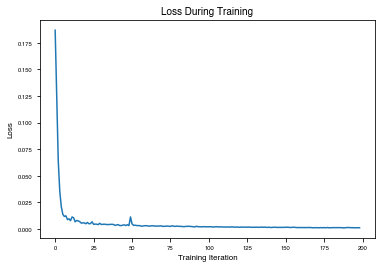

In [15]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

## Test Model

Get a batch of trials from the task to test the network on.

In [16]:
x,y,m, _ = pd.get_trial_batch()

Plot the x value of the trial -- for the PerceptualDiscrimination, this includes two input neurons with different coherence.

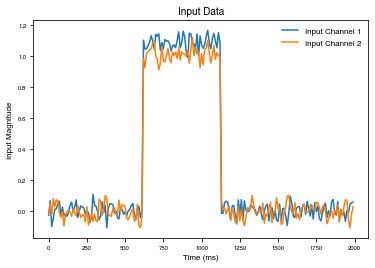

In [17]:
plt.plot(range(0, len(x[0,:,:])*dt,dt), x[0,:,:])
plt.ylabel("Input Magnitude")
plt.xlabel("Time (ms)")
plt.title("Input Data")
plt.legend(["Input Channel 1", "Input Channel 2"])

Run the trained model on this trial (not included in the training set).

In [18]:
output, state_var = basicModel.test(x)

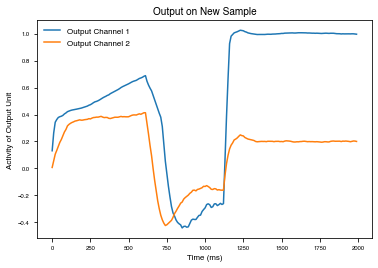

In [19]:
plt.plot(range(0, len(output[0,:,:])*dt,dt),output[0,:,:])
plt.ylabel("Activity of Output Unit")
plt.xlabel("Time (ms)")
plt.title("Output on New Sample")
plt.legend(["Output Channel 1", "Output Channel 2"])

Text(0.5, 1.0, 'Evolution of State Variables over Time')

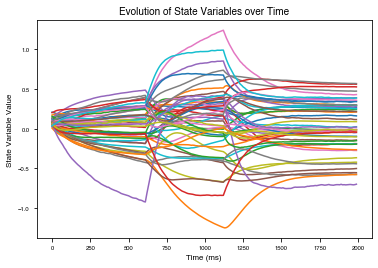

In [20]:
plt.plot(range(0, len(state_var[0,:,:])*dt,dt),state_var[0,:,:])
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.title("Evolution of State Variables over Time")

## Get & Save Model Weights

We can get the weights used by the model in dictionary form using [get_weights](../apidoc/backend.rst#psychrnn.backend.rnn.RNN.get_weights), or we can save the weights directly to a file using [save](../apidoc/backend.rst#psychrnn.backend.rnn.RNN.save).

In [21]:
weights = basicModel.get_weights()

print(weights.keys())

dict_keys(['init_state', 'W_in', 'W_rec', 'W_out', 'b_rec', 'b_out', 'Dale_rec', 'Dale_out', 'input_connectivity', 'rec_connectivity', 'output_connectivity', 'init_state/Adam', 'init_state/Adam_1', 'W_in/Adam', 'W_in/Adam_1', 'W_rec/Adam', 'W_rec/Adam_1', 'W_out/Adam', 'W_out/Adam_1', 'b_rec/Adam', 'b_rec/Adam_1', 'b_out/Adam', 'b_out/Adam_1', 'dale_ratio'])


In [22]:
basicModel.save("./weights/saved_weights")

## Cleanup

Clean up the model to clear out the tensorflow namespace

In [23]:
basicModel.destruct()